In [1]:
pip_list = !pip list
packages = ["keras-tuner", "numpy", "opencv-python", "pandas", "sklearn", "tensorflow", "tensorflow-hub"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


In [2]:
import datetime
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from keras.datasets import cifar10
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14332899076624572548
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17004840559624249194
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
0
MemTotal:       16393696 kB
0
Wed Jun 15 00:52:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M.

2022-06-15 00:52:12.176020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 00:52:12.232172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 00:52:12.353920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 00:52:12.354771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [3]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
MAX_TRIALS = 20
PRETRAINED = 1
EPOCHS = [300, 30][PRETRAINED]
IMAGE_LIMIT = None
IMAGE_SIZE = [80, 224][PRETRAINED]

In [4]:
input_dir = "../input/covid-cxr-image-dataset-research/COVID_IEEE"
X = np.array([cv2.resize(cv2.imread(os.path.join(root, file))[:,:,::-1], (IMAGE_SIZE, IMAGE_SIZE)) for root, _, files in os.walk(input_dir) if len(files) > 1 for file in files[:IMAGE_LIMIT]])
y = np.array([i - 1 for i, (_, _, files) in enumerate(os.walk(input_dir)) if len(files) > 1 for _ in files[:IMAGE_LIMIT]])
labels = dict(enumerate(root.split("/")[-1] for root, _, files in os.walk(input_dir) if len(files) > 1))
print(np.min(np.unique(y, return_counts=True)[-1]), np.unique(y, return_counts=True)[-1], labels)

536 [668 536 619] {0: 'normal', 1: 'covid', 2: 'virus'}


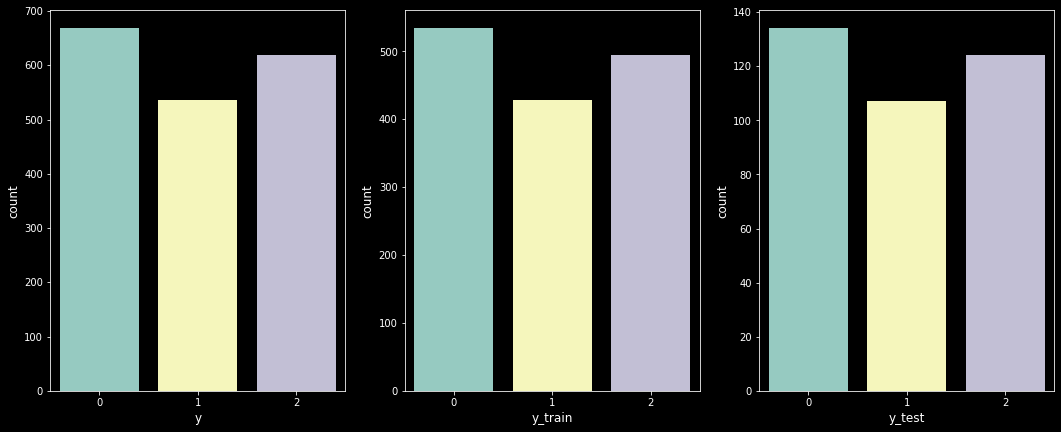

-------------------------------------------------------
X: (1823, 224, 224, 3)	X_train_processed:(1458, 224, 224, 3)	X_test_processed:(365, 224, 224, 3)
y: (1823,)		y_train_processed:(1458,)		y_test_processed:(365,)
-------------------------------------------------------


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
if len(X_train.shape) - 3:
    X_train_processed, y_train_processed, X_test_processed, y_test_processed = X_train.astype("float32") / 255.0, y_train, X_test.astype("float32") / 255.0, y_test
else:
    X_train_processed, y_train_processed, X_test_processed, y_test_processed = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1) / 255.0, y_train, X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1) / 255.0, y_test
fig, ax = plt.subplots(nrows=1, ncols=3)
sns.countplot(y, ax=ax[0]).set_xlabel("y")
sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
sns.countplot(y_test, ax=ax[2]).set_xlabel("y_test")
plt.show()
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train_processed:{X_train_processed.shape}\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\t\ty_train_processed:{y_train_processed.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

2022-06-15 00:53:24.682197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 00:53:24.683101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 00:53:24.683740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 00:53:24.684440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 00:53:24.685081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

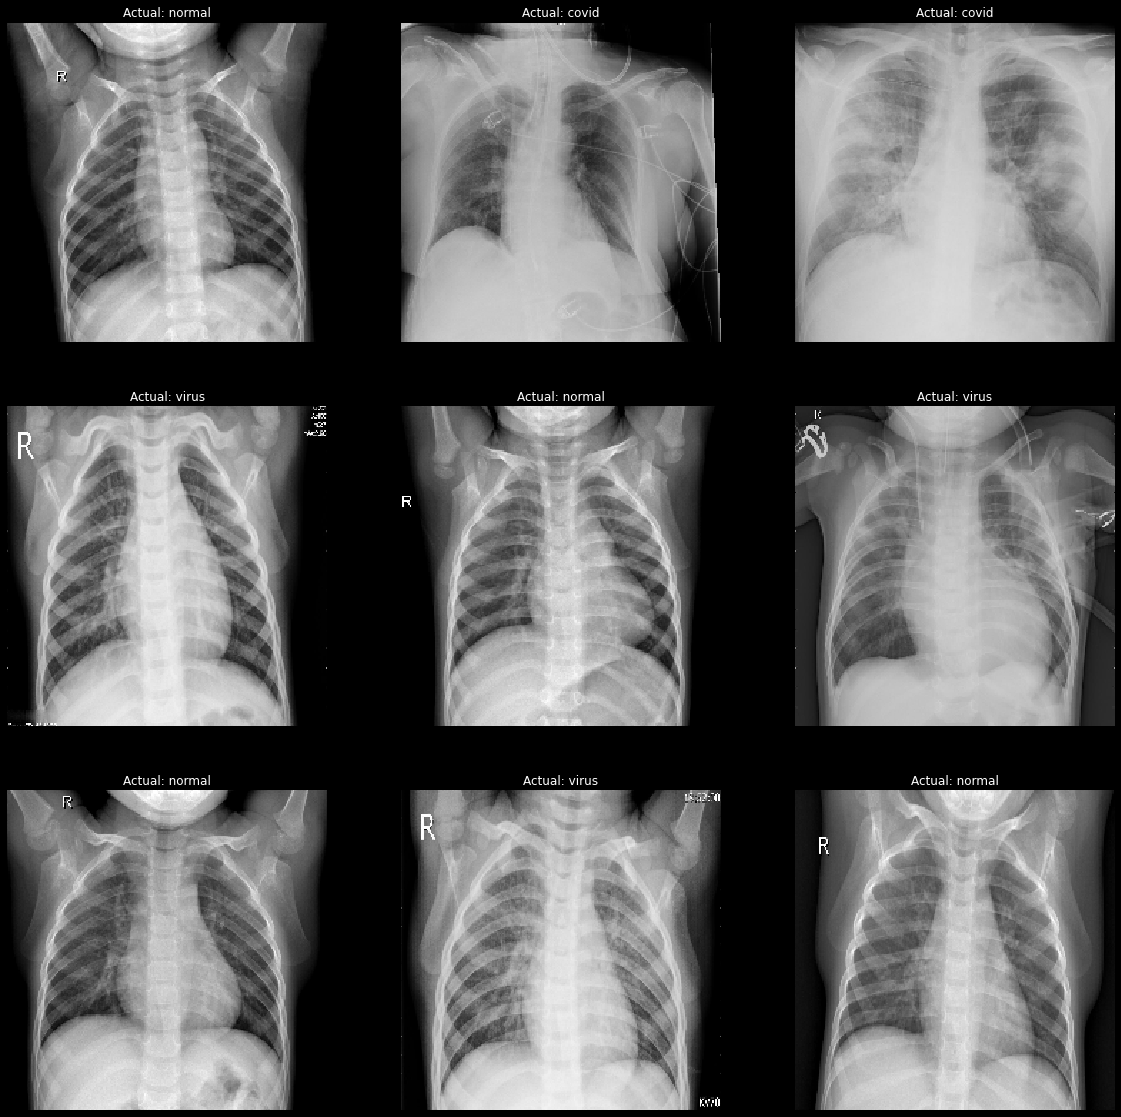

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [6]:
def show_image(X, y, labels, model=None):
    _, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    for rows in ax:
        for col in rows:
            i = np.random.randint(0, len(X))
            col.axis("off")
            col.imshow(X[i], interpolation="none")
            if len(labels):
                col.set_title(f"Actual: {labels.get(y[i])} vs Prediction: {labels.get(np.argmax(model.predict(X[i:i+1])[0]))}, Confidence: {int(np.max(model.predict(X[i:i+1])[0]) * 100)}%" if model else f"Actual: {labels.get(y[i])}")
            else:
                col.set_title(f"Actual: {y[i]} vs Prediction: {np.argmax(model.predict(X[i:i+1])[0])}, Confidence: {int(np.max(model.predict(X[i:i+1])[0]) * 100)}%" if model else f"Actual: {y[i]}")
    plt.show()


def tune_dl_model(hp):
    model = keras.models.Sequential()
    if PRETRAINED:
        model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=X_train_processed.shape[1:], trainable=False))
    else:
        model.add(keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=X_train_processed.shape[1:]))
        model.add(keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2))
        model.add(keras.layers.experimental.preprocessing.RandomHeight(0.1))
        model.add(keras.layers.experimental.preprocessing.RandomWidth(0.1))
        model.add(keras.layers.experimental.preprocessing.RandomZoom(0.25))
        model.add(keras.layers.experimental.preprocessing.RandomRotation(0.2))
        model.add(keras.layers.experimental.preprocessing.RandomContrast(0.5))
        model.add(keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE))
        for i in range(hp.Int("num_layers", min_value=1, max_value=3, step=1)):
            model.add(
                keras.layers.Conv2D(
                    filters=hp.Int(f"conv_{i:02}_filter", min_value=32, max_value=512, step=32),
                    kernel_size=hp.Choice(f"conv_{i:02}_kernel", values=[3, 5]),
                    activation="relu",
                    padding="same",
                )
            )
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.MaxPooling2D(pool_size=hp.Choice("pool_size", values=[2])))
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
        model.add(keras.layers.Flatten()),
        for i in range(hp.Int("num_layers", min_value=1, max_value=16, step=1)):
            model.add(
                keras.layers.Dense(
                    units=hp.Int(f"dense_{i:02}_unit", min_value=32, max_value=512, step=32),
                    activation="relu",
                )
            )
            model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=len(set(y_train)), activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics="accuracy",
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
    )
    val_per_epoch = history.history["val_accuracy"]
    best_epoch = val_per_epoch.index(max(val_per_epoch)) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history["accuracy"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_accuracy"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()
    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
    )
    classification_report_test = classification_report(
        y_test_processed,
        np.argmax(model.predict(X_test_processed), axis=1),
        output_dict=True,
    )
    print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
    classification_report_train = classification_report(
        y_train_processed,
        np.argmax(model.predict(X_train_processed), axis=1),
        output_dict=True,
    )
    print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
    print("-------------------------------------------------------")
    print(classification_report(y_test_processed, np.argmax(model.predict(X_test_processed), axis=1)))
    sns.heatmap(
        tf.math.confusion_matrix(y_test_processed, np.argmax(model.predict(X_test_processed), axis=1)),
        cmap="Blues",
        fmt="d",
        annot=True,
        linewidths=1,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective="val_accuracy",
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective="val_accuracy",
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective="val_accuracy",
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

show_image(X, y, labels)
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Trial 3 Complete [00h 00m 10s]
val_accuracy: 0.8219178318977356

Best val_accuracy So Far: 0.9212328791618347
Total elapsed time: 00h 00m 47s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9212328791618347
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.8219178318977356
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.4931506812572479
Epoch 1/30
5/5 [==============================] - 5s 525ms/step - loss: 2.0725 - accuracy: 0.3962 - val_loss: 1.3058 - val_accuracy: 0.4966
Epoch 2/30
5/5 [==============================] - 1s 253ms/step - loss: 0.7625 - accuracy: 0.7247 - val_loss: 0.3757 - val_accuracy: 0.8493
Epoch 3/30
5/5 [==============================] - 1s 259ms/step - l

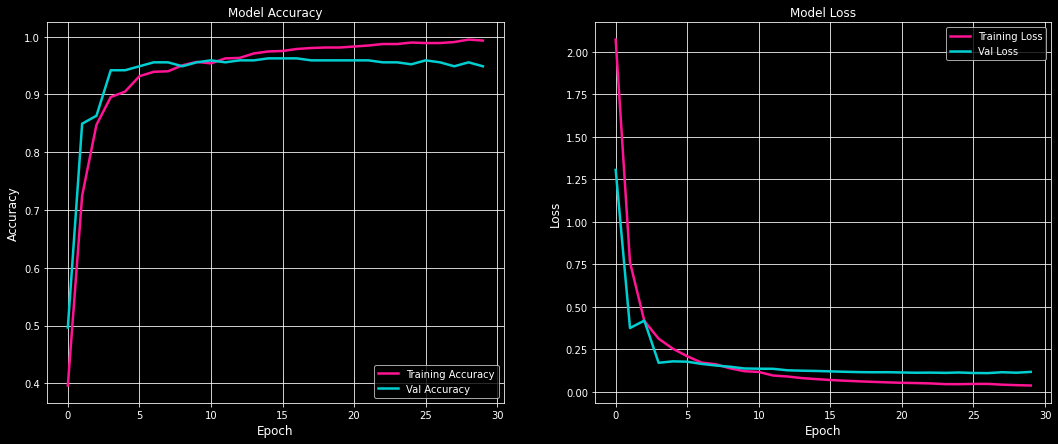

Best epoch: 15
Epoch 1/15
5/5 [==============================] - 4s 432ms/step - loss: 2.2433 - accuracy: 0.5377 - val_loss: 0.7542 - val_accuracy: 0.6130
Epoch 2/15
5/5 [==============================] - 1s 247ms/step - loss: 0.7617 - accuracy: 0.6681 - val_loss: 0.6321 - val_accuracy: 0.7466
Epoch 3/15
5/5 [==============================] - 1s 247ms/step - loss: 0.4708 - accuracy: 0.8285 - val_loss: 0.2308 - val_accuracy: 0.9349
Epoch 4/15
5/5 [==============================] - 1s 249ms/step - loss: 0.3123 - accuracy: 0.8894 - val_loss: 0.1567 - val_accuracy: 0.9452
Epoch 5/15
5/5 [==============================] - 1s 278ms/step - loss: 0.2353 - accuracy: 0.9194 - val_loss: 0.2127 - val_accuracy: 0.9212
Epoch 6/15
5/5 [==============================] - 1s 256ms/step - loss: 0.2046 - accuracy: 0.9245 - val_loss: 0.1506 - val_accuracy: 0.9589
Epoch 7/15
5/5 [==============================] - 1s 251ms/step - loss: 0.1699 - accuracy: 0.9374 - val_loss: 0.1419 - val_accuracy: 0.9623
Epoch

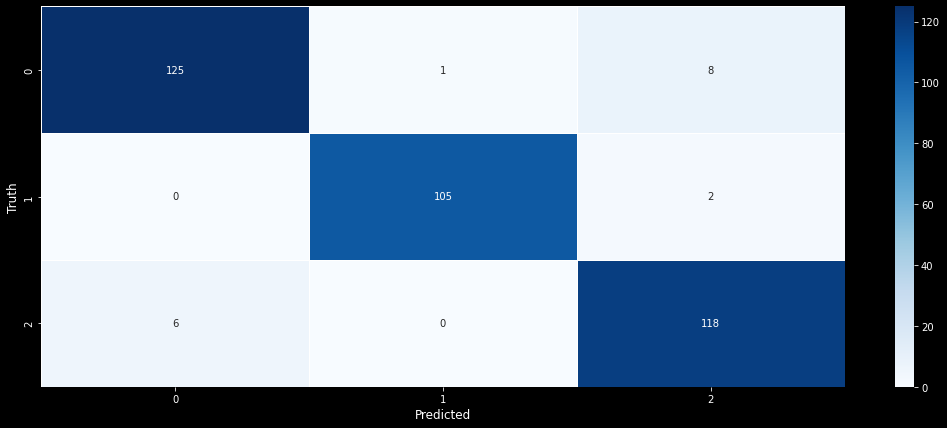

In [7]:
model = build_dl_model(*train_dl_model())

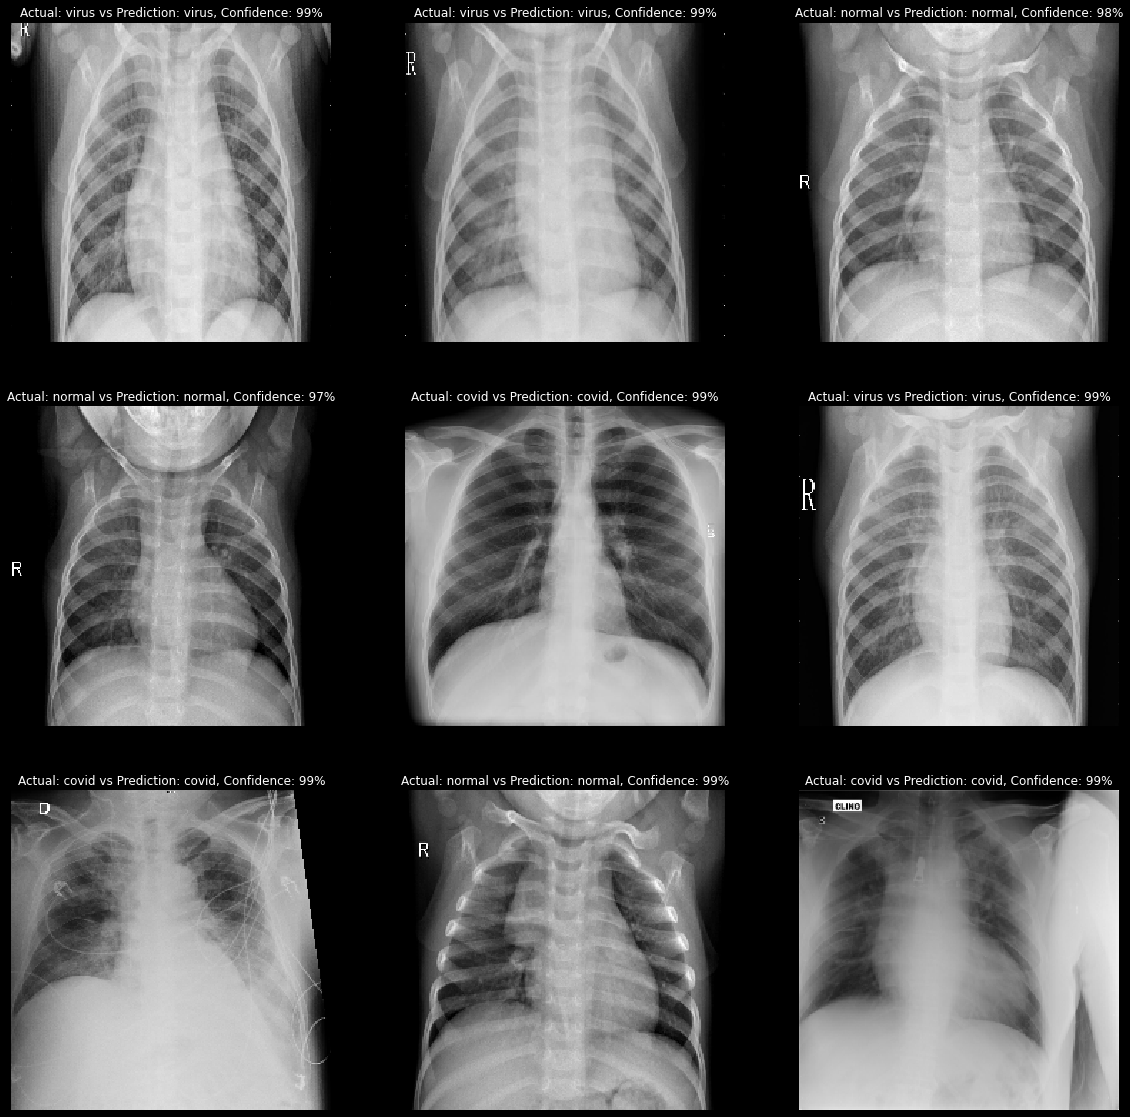

In [8]:
show_image(X_test_processed, y_test_processed, labels, model)

2022-06-15 00:55:34.778776: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


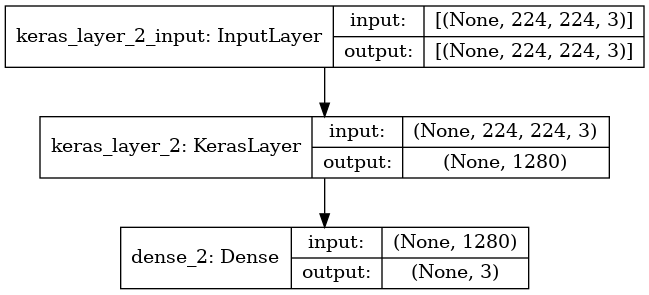

In [9]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
model.summary()
plot_model(model, show_shapes=True)